In [1]:
import numpy as np
import pandas as pd
import scipy
import datetime
import seaborn as sns
import os
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import BaggingClassifier
%matplotlib inline

In [2]:
filename = 'data.csv'
df_origin = pd.read_csv(filename, sep=',', engine='python')

In [3]:
df_origin.columns

Index(['eventid', 'iyear', 'imonth', 'iday', 'approxdate', 'extended',
       'resolution', 'country', 'country_txt', 'region',
       ...
       'addnotes', 'scite1', 'scite2', 'scite3', 'dbsource', 'INT_LOG',
       'INT_IDEO', 'INT_MISC', 'INT_ANY', 'related'],
      dtype='object', length=135)

### data representation: category explain

In [4]:
df_origin['weaptype1_txt'].unique()

array(['Unknown', 'Explosives', 'Incendiary', 'Firearms', 'Chemical',
       'Melee', 'Sabotage Equipment',
       'Vehicle (not to include vehicle-borne explosives, i.e., car or truck bombs)',
       'Fake Weapons', 'Radiological', 'Other', 'Biological'],
      dtype=object)

In [5]:
df_origin['attacktype1_txt'].unique()

array(['Assassination', 'Hostage Taking (Kidnapping)',
       'Bombing/Explosion', 'Facility/Infrastructure Attack',
       'Armed Assault', 'Hijacking', 'Unknown', 'Unarmed Assault',
       'Hostage Taking (Barricade Incident)'], dtype=object)

In [6]:
df_origin['targtype1_txt'].unique()

array(['Private Citizens & Property', 'Government (Diplomatic)',
       'Journalists & Media', 'Police', 'Utilities', 'Military',
       'Government (General)', 'Airports & Aircraft', 'Business',
       'Educational Institution', 'Violent Political Party',
       'Religious Figures/Institutions', 'Unknown', 'Transportation',
       'Tourists', 'NGO', 'Telecommunication', 'Food or Water Supply',
       'Terrorists/Non-State Militia', 'Other', 'Maritime',
       'Abortion Related'], dtype=object)

In [7]:
len(df_origin['country_txt'].unique())

205

In [8]:
df_origin['gname'].unique()

array(['MANO-D', '23rd of September Communist League', 'Unknown', ...,
       'Fatoni Warriors', 'Minorities of Metropolitan Attacks',
       'Baloch Republican Party'], dtype=object)

### data preprocessing

#### data cleaning

In [9]:
df = df_origin[['iyear','imonth','iday','country','region','latitude','longitude',
                'success','attacktype1','individual','nkill','nwound','suicide',
                'weaptype1','targtype1','gname','guncertain1','specificity','vicinity','multiple']]

In [10]:
# drop nan value rows
df = df.dropna(axis=0,how='any')

# drop nonsense date rows
df = df[df['iday']>=1]
df = df[df['iday']<=31]
df = df[df['imonth']<=12]
df = df[df['imonth']>=1]

# drop unclear unknown weapon type, unknown attack type, unknown target type
df = df[df['weaptype1']!=13]
df = df[df['targtype1']!=20]
df = df[df['attacktype1']!=9]

In [11]:
# the remaning proportion
len(df) / len(df_origin)

0.7878871270453682

#### create column weekday

In [12]:
from datetime import datetime

In [13]:
df['date'] = df['iyear'].map(str) +'-' + df['imonth'].map(str) +'-'+ df['iday'].map(str)
df['date'] = df['date'].apply(lambda x : datetime.strptime(x, '%Y-%m-%d'))
df['weekday'] = df['date'].apply(lambda x: x.isoweekday())

#### data glimpse

In [14]:
df[:5]

,iyear,imonth,iday,country,region,latitude,longitude,success,attacktype1,individual,...,suicide,weaptype1,targtype1,gname,guncertain1,specificity,vicinity,multiple,date,weekday
5,1970,1,1,217,1,37.005105,-89.176269,1,2,0,...,0,5,3,Black Nationalists,0.0,1.0,0,0.0,1970-01-01,4
6,1970,1,2,218,3,-34.891151,-56.187214,0,1,0,...,0,5,3,Tupamaros (Uruguay),0.0,1.0,0,0.0,1970-01-02,5
7,1970,1,2,217,1,37.791927,-122.225906,1,3,0,...,0,6,21,Unknown,0.0,1.0,0,0.0,1970-01-02,5
8,1970,1,2,217,1,43.076592,-89.412488,1,7,0,...,0,8,4,New Year's Gang,0.0,1.0,0,0.0,1970-01-02,5
9,1970,1,3,217,1,43.072950,-89.386694,1,7,0,...,0,8,2,New Year's Gang,0.0,1.0,0,0.0,1970-01-03,6


### Logistic Regression: Predict success

### Random Forest: Predict success

#### Verify Correlation Matrix

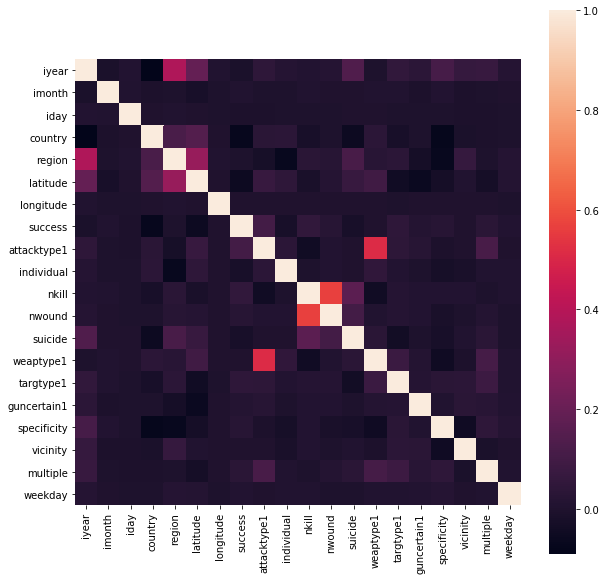

In [15]:
corrmat = df.corr()
f, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(corrmat, vmax=1, square=True)

#### Ensemble Random Forest Model

In [16]:
X = df[['weekday','country','region','attacktype1','individual','suicide','weaptype1','targtype1','guncertain1','specificity','vicinity','multiple']]
Y = df['success']

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
parameters = {
     'n_estimators':(5,10,15), #the number of trees
     'max_depth':(4,6,8,10),
     'min_samples_split': (4,6,8),
     'min_samples_leaf': (4,8,12,16),
}

RFC = GridSearchCV(RandomForestClassifier(),parameters,cv=3,iid=False)
RFC.fit(x_train, y_train)
par = RFC.best_params_
print('Parameters:',par)

Parameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 15}


In [17]:
RFC = RandomForestClassifier(max_depth=par['max_depth'],min_samples_leaf=par['min_samples_split'],
                             min_samples_split=par['min_samples_split'],n_estimators=par['n_estimators'])
RFC.fit(x_train, y_train)
print('Accuracy: ', RFC.score(x_test,y_test))

y_pred = RFC.predict(x_test)
cfm = confusion_matrix(y_test,y_pred)
print('Confusion Matrix: \n',cfm)

Accuracy:  0.9080367433900318
Confusion Matrix: 
 [[  320  2521]
 [  112 25678]]


#### Feature Importance

Text(0.5,0,'Relative Importance')

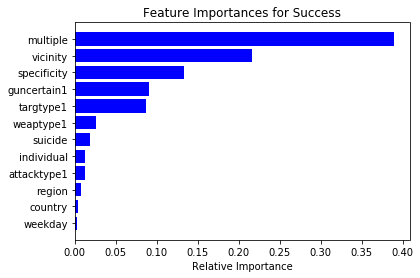

In [18]:
feature_names = [i for i in X.columns]
importances = RFC.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances for Success')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)),feature_names)
plt.xlabel('Relative Importance')

#### Bootstrapping

In [19]:
parameters = {
     'n_estimators':(5,10,15), #the number of trees
     'max_samples':(10,20,40),
     'max_features':(3,5,10),
}

model = GridSearchCV(BaggingClassifier(),parameters,cv=3,iid=False)
model.fit(x_train, np.ravel(y_train))
bpar = model.best_params_

In [20]:
BC = BaggingClassifier(max_features=bpar['max_features'],max_samples=bpar['max_samples'],
                       n_estimators=bpar['n_estimators'])
BC.fit(x_train,y_train)
print('Accuracy:',BC.score(x_test,y_test))

Accuracy: 0.9007718906080822
